2022136115 정희연

## **1. titanic_dataset.py 분석하기**

In [35]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split


class TitanicDataset(Dataset):
  # 초기화 함수. 데이터셋을 생성하면 호출된다.
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X) # 입력 데이터를 FloatTensor 형식으로
    self.y = torch.LongTensor(y) # 타겟 데이터를 LongTensor 형식으로

  # 데이터셋의 총 샘플 수
  def __len__(self):
    return len(self.X)

  # 인덱스에 해당하는 입력과 타겟 데이터
  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  # 데이터셋 정보 출력 함수
  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [37]:
class TitanicTestDataset(Dataset):
  # 초기화 함수
  def __init__(self, X):
    self.X = torch.FloatTensor(X)

  # 데이터셋의 총 샘플 수 반환
  def __len__(self):
    return len(self.X)

  # 인덱스에 해당하는 입력 데이터 반환
  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  # 데이터 크기와 입력 데이터 모양 반환
  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [38]:
def get_preprocessed_dataset():
    # 현재 파일 경로를 가져와서 저장한다.
    CURRENT_FILE_PATH = os.getcwd()

    # 학습 데이터와 테스트 데이터의 경로를 설정한다.
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    # CSV 파일을 Pandas DataFrame으로 읽어온다.
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 학습 데이터와 테스트 데이터를 합친다.
    all_df = pd.concat([train_df, test_df], sort=False)

    # 데이터 전처리 단계
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # Survived 열을 기준으로 학습 데이터와 테스트 데이터로 나눈다.
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    # 테스트 데이터
    # Survived 열이 비어 있는 데이터만 선택한다.
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # TitanicDataset 인스턴스를 생성하여 전체 학습 데이터셋을 만들고
    # 학습 및 검증 데이터셋으로 분리한다.
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])

    # TitanicTestDataset 인스턴스 생성
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

In [39]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    # 평균값을 all_df에 병합
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [40]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    # 분리된 컬럼을 기존 데이터에 추가
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [41]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    # 중간 컬럼 제거
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [42]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"] = all_df["alone"].fillna(0)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [43]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    # Embarked 열의 결측피를 missing으로 채우기
    all_df["Embarked"] = all_df["Embarked"].fillna("missing")

    return all_df

In [44]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    # 문자열 타입 열 선택
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        # 각 범주형 열에 대해 LabelEncoder 인스턴스 생성
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          # 범주형 열을 숫자로 변환
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

In [45]:
from torch import nn
# MyModel: 입력과 출력 크기를 받아 만드는 신경망 모델 클래스
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, 30),    # 첫 번째 레이어: 입력에서 30개의 노드로 연결
      nn.ReLU(),                 # 활성화 함수: ReLU
      nn.Linear(30, 30),         # 두 번째 레이어: 30개의 노드에서 다시 30개의 노드로 연결
      nn.ReLU(),                 # 활성화 함수: ReLU
      nn.Linear(30, n_output),   # 출력 레이어: 30개의 노드에서 출력 크기로 연결
    )

  # 순전파 함수
  def forward(self, x):
    x = self.model(x)
    return x

In [46]:
# 테스트 함수
def run_test(test_data_loader):
  print("[TEST]")
  batch = next(iter(test_data_loader))
  print("{0}".format(batch['input'].shape))
  my_model = MyModel(n_input=11, n_output=2) # 모델 인스턴스 생성
  output_batch = my_model(batch['input'])    # 모델을 통해 예측 값 계산
  prediction_batch = torch.argmax(output_batch, dim=1) # 예측 값에서 가장 큰 값을 가지는 인덱스 선택
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())

In [47]:
if __name__ == "__main__":
  # 데이터셋을 가져오고 학습/검증/테스트 데이터셋으로 나누기
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  # DataLoader를 사용하여 데이터셋을 배치 단위로 나누고 섞어서 처리
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  # 학습 데이터 로더
  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  # 검증 데이터 로더
  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  # 테스트 함수 실행
  run_test(test_data_loader)

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 1.0000,  1.0000, 48.0000,  1.0000,  0.0000, 76.7292,  0.0000, 87.5090,
         2.0000,  1.0000,  0.0000]): 1
1 - tensor([  1.0000,   1.0000,  35.0000,   0.0000,   0.0000, 512.3292,   0.0000,
         87.5090,   2.0000,   0.0000,   1.0000]): 1
2 - tensor([ 1.0000,  0.0000, 38.0000,  1.0000,  0.0000, 71.2833,  0.0000, 87.5090,
         3.0000,  1.0000,  0.0000]): 1
3 - tensor([ 3.0000,  1.0000, 20.0000,  0.0000,  0.0000,  9.2250,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
4 - tensor([ 3.0000,  1.0000, 17.0000,  1.0000,  1.0000,  7.2292,  0.0000, 13.3029,
         2.0000,  2.0000,  0.0000]): 0
5 - tensor([ 2.0000,  0.0000, 35.0000,  0.0000,  0.0000, 21.0000,  2.0000, 21.1792,
         1.0000,  0.0000,  1.0000]): 1
6 - tensor([ 3.0000,  1.0000,  3.0000,  1.0000,  1.0000, 15.9000,  2.0000, 13.3029,
         0.0000,  2.0000,  0.0000]): 1
7 - te

<br/><br/> 

## **2. titanic 딥러닝 모델 훈련 코드 및 Actication Function 변경하기**

PReLU, ReLU, ELU, Leaky ReLU 활성화 함수를 모두 사용해보았다.

<br/><br/> 

## **3. 테스트 및 submission.csv 생성하기**

PReLU, ReLU, ELU, Leaky ReLU 중 검증 정확도가 가장 좋았던 Leaky ReLU를 선택했다.
에포크 1000까지 훈련을 진행하면서 매 100번째 에포크마다 성능을 확인할 수 있게 했다.
500~700 에서 검증 성능이 제일 높은 것을 알 수 있었다.

<br/><br/> 

## **4. submission 제출 및 등수 확인하기**

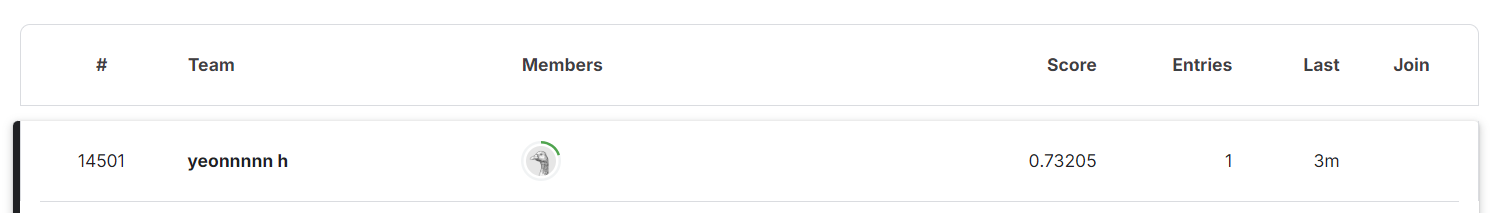

<br/><br/> 

## **5. Training Loss, Validation Loss 그래프**

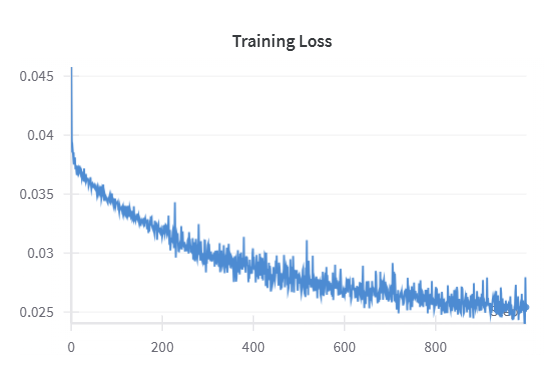

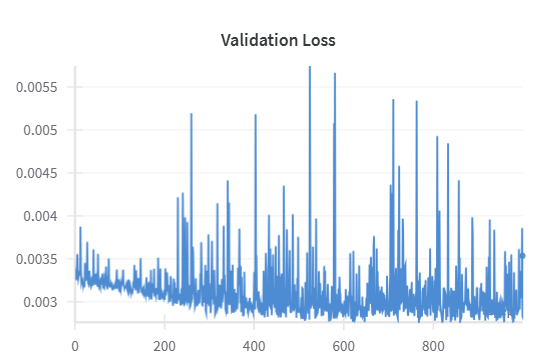

###### <br/><br/> 

## **6. 숙제 후기**

다양한 활성화 함수를 직접 적용해보면서 결과가 그래프로 만들어지는 과정이 재밌었다. 특히 각 함수가 학습 성능에 미치는 영향을 비교하고 확인하는 과정에서 단순히 수식으로만 접했던 활성화 함수들이 실질적으로 모델의 성능에 얼마나 중요한 역할을 하는지 깨잘았다.